# Fitting integral field data with pPXF

In [64]:
import astropy.io.fits as pyfits
import numpy as np
import matplotlib.pyplot as plt
from os import path

import ppxf as ppxf_package
from ppxf.ppxf import ppxf, robust_sigma
import ppxf.ppxf_util as util
import ppxf.miles_util as lib
from vorbin.voronoi_2d_binning import voronoi_2d_binning

C = 299792.458  # speed of light in km/s

## Function to read the MUSE cube

In [65]:
class read_muse_cube(object):
    def __init__(self, wave_range):
        """
        Read MUSE cube, log rebin it and compute coordinates of each spaxel.
        Median FWHM resolution = 2.62AA. Range: 2.51--2.88 (ESO instrument manual)
        """
        filename = '../../../Dati/LVS_JWST_workshop_rodeo_cube.fits'  # NGC1386
        hdu = pyfits.open(filename)
        head = hdu[0].header
        cube = hdu[0].data   # cube.shape = (3681, nx, ny)

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1) # create array of spectra [npix, nx*ny]
        wave = head['CRVAL3'] + head['CDELT3']*np.arange(npix)
        pixsize = abs(head["CDELT1"])*3600    # 0.2"

        # Only use the wavelength range in common between galaxy and stellar library.
        w = (wave > wave_range[0]) & (wave < wave_range[1])
        spectra = spectra[w, :]
        wave = wave[w]

        # Create coordinates centred on the brightest spectrum
        flux = np.nanmean(spectra, 0)
        jm = np.argmax(flux)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*pixsize
        y = (row - row[jm])*pixsize
        velscale = C*np.diff(wave[:2])/wave[-1]    # Smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)
        
        self.spectra = spectra
        self.x = x
        self.y = y
        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.flux = flux
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = 2.62  # Median FWHM resolution of MUSE

## Function to iteratively clip the outliers

In [66]:
def clip_outliers(galaxy, bestfit, goodpixels):
    """
    Repeat the fit after clipping bins deviants more than 3*sigma
    in relative error until the bad bins don't change any more.
    """
    while True:
        scale = galaxy[goodpixels] @ bestfit[goodpixels]/np.sum(bestfit[goodpixels]**2)
        resid = scale*bestfit[goodpixels] - galaxy[goodpixels]
        err = robust_sigma(resid, zero=1)
        ok_old = goodpixels
        goodpixels = np.flatnonzero(np.abs(bestfit - galaxy) < 3*err)
        if np.array_equal(goodpixels, ok_old):
            break
            
    return goodpixels

#############################################################################

In [67]:
def fit_and_clean(templates, galaxy, velscale, start, goodpixels0, dv, lam):
    goodpixels = goodpixels0.copy()
    print('##############################################################')
    pp = ppxf(templates, galaxy, galaxy*0 + 1, velscale, start,
              moments=2, degree=-1, mdegree=8, vsyst=dv, goodpixels=goodpixels, lam=lam)
    plot = True
    if plot:
        plt.clf()
        plt.subplot(211)
        pp.plot()
    goodpixels = clip_outliers(galaxy, pp.bestfit, goodpixels)

    # Add clipped pixels to the original masked emission lines regions
    goodpixels = np.intersect1d(goodpixels, goodpixels0)
    pp = ppxf(templates, galaxy, galaxy*0 + 1, velscale, start,
              moments=2, degree=-1, mdegree=8, vsyst=dv, goodpixels=goodpixels, lam=lam)
    if plot:
        plt.subplot(212)
        pp.plot()
        plt.pause(0.1)
    optimal_template = templates @ pp.weights if templates.ndim == 2 else templates
    return pp, optimal_template

#############################################################################

In [68]:
lam_range_temp = [3540, 7409]   # Wavelength range of MILES library
s = read_muse_cube(lam_range_temp)
lam_gal = np.exp(s.ln_lam_gal)
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]

In [69]:
signal = np.median(s.spectra, 0)
noise = np.sqrt(signal)
targetSN = 350

Bin-accretion...
1  /  9
2  /  9
3  /  9
4  /  9
5  /  9
6  /  9
7  /  9
8  /  9
9  /  9
10  /  9
11  /  9
12  /  9
13  /  9
13  initial bins.
Reassign bad bins...
9  good bins.
Modified Lloyd algorithm...
Iter:    1  Diff: 2.993
Iter:    2  Diff: 1.066
Iter:    3  Diff: 0.9984
Iter:    4  Diff: 0.5387
Iter:    5  Diff: 0.3838
Iter:    6  Diff: 0.4701
Iter:    7  Diff: 0.5214
Iter:    8  Diff: 0.3273
Iter:    9  Diff: 0.3003
8  iterations.
Unbinned pixels:  0  /  900
Fractional S/N scatter (%): 8.557297938759246
Elapsed time accretion: 0.18 seconds
Elapsed time optimization: 0.01 seconds


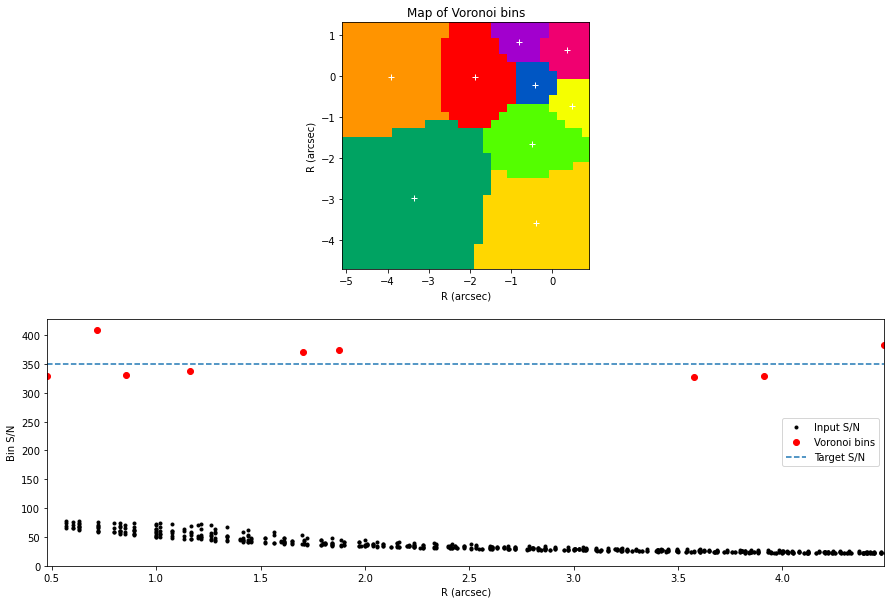

In [70]:
plt.figure(figsize=(15,10))
bin_num, x_gen, y_gen, xbin, ybin, sn, nPixels, scale = voronoi_2d_binning(
    s.x, s.y, signal, noise, targetSN, plot=1, quiet=0, pixelsize=0.2)

In [71]:
velscale = C*np.diff(s.ln_lam_gal[:2]).item()   # eq.(8) of Cappellari (2017)

## Setup stellar templates

In [72]:
ppxf_dir = path.dirname(path.realpath(ppxf_package.__file__))
pathname = ppxf_dir + '/miles_models/Mun1.30*.fits'
FWHM_gal = 2.51   # Same as MILES ==> skip templates broadening
miles = lib.miles(pathname, velscale, FWHM_gal, norm_range=[5070, 5950])
stars_templates, ln_lam_temp = miles.templates, miles.ln_lam_temp
lam_range_temp = np.exp(ln_lam_temp[[0, -1]])

stars_templates, lam_range_temp, ln_lam_temp = setup_miles_stars(velscale)

The stellar templates are reshaped into a 2-dim array with each spectrum<br>
as a column, however we save the original array dimensions, which are<br>
needed to specify the regularization dimensions<br>


In [73]:
reg_dim = stars_templates.shape[1:]
stars_templates = stars_templates.reshape(stars_templates.shape[0], -1)

See the pPXF documentation for the keyword REGUL,<br>
for an explanation of the following two lines<br>


In [74]:
stars_templates /= np.median(stars_templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

Construct a set of Gaussian emission line templates<br>


In [75]:
gas_templates, gas_names, line_wave = util.emission_lines(ln_lam_temp, lam_range_gal, s.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007_d' '[OI]6300_d'
 '[NII]6583_d']


---------------------Fit global template-------------------------

In [76]:
dv = C*(np.log(lam_range_temp[0]) - s.ln_lam_gal[0])  # km/s

In [77]:
z = 0.002895  # redshift estimate from NED
vel0 = C*np.log(1 + z)  # Initial estimate of the galaxy velocity in km/s
start = [vel0, 200.]  # (km/s), starting guess for [V,sigma]

In [78]:
goodpixels0 = util.determine_goodpixels(s.ln_lam_gal, lam_range_temp, z, width=1000)

In [79]:
plt.clf()

<Figure size 432x288 with 0 Axes>

---------------------Fit stars individual bins-------------------------

In [80]:
nbins = sn.size
velbin, sigbin, nspax = np.zeros((3, nbins))
optimal_templates = np.empty((stars_templates.shape[0], nbins))

In [81]:
npix = s.x.size
ngas_comp = 3
gas_vel, gas_sig = np.zeros((2, npix, ngas_comp))

In [82]:
nlines = 4  #  [NII], Halpha, [OIII], Hbeta
gas_flux, gas_sn = np.zeros((2, npix, ngas_comp, nlines))

In [83]:
moments_stars = 2  # Gauss-Hermite moments to fit in the cleaned spectrum

In [84]:
%matplotlib inline

##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       856       111
chi2/DOF: 1.210e+07; degree = -1; mdegree = 8
method = capfit; Jac calls: 5; Func calls: 57; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 150
 Best Fit:       Vel     sigma
 comp.  0:       854       114
chi2/DOF: 2.351e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 94; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  2 / 150


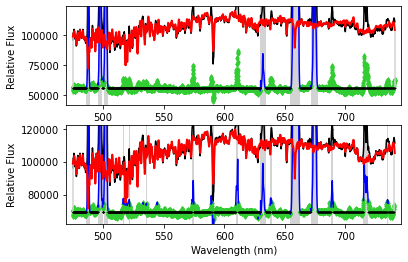

bin: 0 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       930       110
chi2/DOF: 4.927e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 5; Func calls: 57; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       935       114
chi2/DOF: 1.221e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 93; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


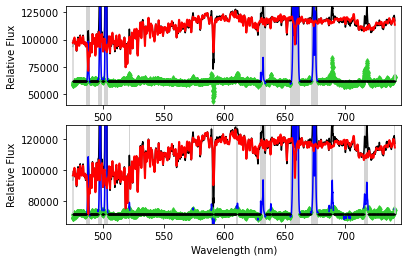

bin: 1 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       894       126
chi2/DOF: 3.859e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 6; Func calls: 69; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       894       129
chi2/DOF: 1.096e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 8; Func calls: 93; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


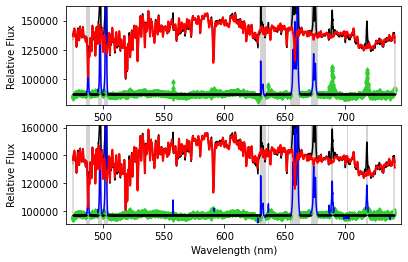

bin: 2 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       813       113
chi2/DOF: 2.139e+07; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       822       125
chi2/DOF: 1.472e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 9; Func calls: 101; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


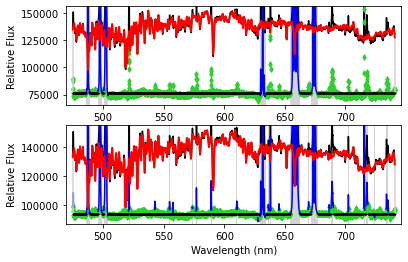

bin: 3 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       856        96
chi2/DOF: 4.910e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 5; Func calls: 61; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  6 / 150
 Best Fit:       Vel     sigma
 comp.  0:       856        97
chi2/DOF: 9.914e+05; degree = -1; mdegree = 8
method = capfit; Jac calls: 9; Func calls: 103; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


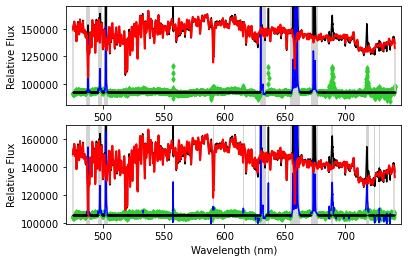

bin: 4 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       902       105
chi2/DOF: 2.488e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 4
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 150
 Best Fit:       Vel     sigma
 comp.  0:       902       106
chi2/DOF: 5.321e+05; degree = -1; mdegree = 8
method = capfit; Jac calls: 9; Func calls: 104; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


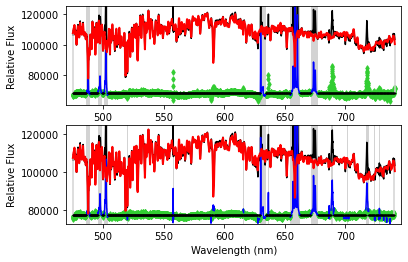

bin: 5 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       814       109
chi2/DOF: 2.802e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma
 comp.  0:       815       111
chi2/DOF: 5.519e+05; degree = -1; mdegree = 8
method = capfit; Jac calls: 10; Func calls: 114; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150


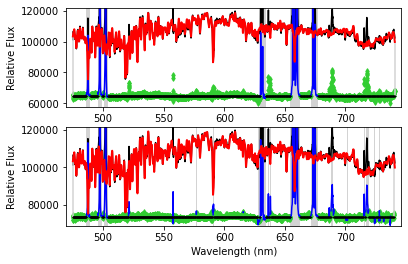

bin: 6 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       796        97
chi2/DOF: 8.670e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 4; Func calls: 46; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150
 Best Fit:       Vel     sigma
 comp.  0:       800       101
chi2/DOF: 1.646e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 6; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150


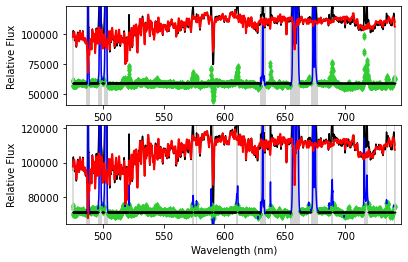

bin: 7 / 9
##############################################################
 Best Fit:       Vel     sigma
 comp.  0:       879       105
chi2/DOF: 3.000e+07; degree = -1; mdegree = 8
method = capfit; Jac calls: 6; Func calls: 68; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 150
 Best Fit:       Vel     sigma
 comp.  0:       884       110
chi2/DOF: 4.972e+06; degree = -1; mdegree = 8
method = capfit; Jac calls: 11; Func calls: 125; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  3 / 150


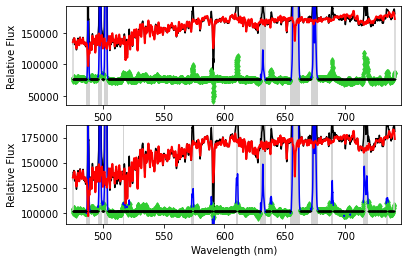

bin: 8 / 9


In [85]:
for j in range(nbins):
    w = bin_num == j
    nspax[j] = w.sum()
    galaxy = np.sum(s.spectra[:, w], 1)
    pp, templates_fitted = fit_and_clean(stars_templates, galaxy, velscale, start, goodpixels0, dv, lam_gal)
    velbin[j], sigbin[j] = pp.sol
    optimal_templates[:, j] = templates_fitted
    print(f'bin: {j} / {nbins}')

---------------------Fit gas all spaxels-------------------------

In [86]:
nlines = 4  #  [NII], Halpha, [OIII], Hbeta
gas_flux, gas_sn = np.zeros((2, npix, ngas_comp, nlines))

Create three sets of gas templates for the same emission lines

In [87]:
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

In [88]:
vsyst = np.median(velbin)

In [89]:
j = 765

In [90]:
galaxy = s.spectra[:, j]

Use galaxy template from the bin containing the current spaxel<br>
keeping the stellar kinematic fixed to that of the bin

In [91]:
k = bin_num[j]
template = optimal_templates[:, k]

Fit global template and only gas emission

In [92]:
stars_gas_templates = np.column_stack([template, gas_templates])
component = [0]  # Single stellar kinematic component=0

'Hbeta' 'Halpha' '[SII]6716' '[SII]6731' '[OIII]5007d' '[OI]6300d' '[NII]6583d'<br>
I put the narrow lines all in the same component=1<br>
and all secondary component in another component=2<br>
and all broad components in another component=3

In [93]:
component += [1]*7
component += [2]*7
component += [3]*7
component = np.asarray(component)

do not fit stars (negative moments) but use previous solution<br>
fit two moments=2 (V, sigma) for the 2 gas components

In [94]:
moments_stars_gas = [-moments_stars, 2, 2, 2]

[[V1, sig1], [V2, sig2], [V3, sig3], [V4, sig4]]<br>
ncomp = len(moments_stars_gas)<br>
tied = [['', ''] for j in range(ncomp)]<br>
tied[2][1] = 'p[3]'                 # sig3 = sig2<br>
tied[3][0] = '(p[2] + p[4])/2'      # V4 = (V2 + V3)/2

In [95]:
tied = None

In [96]:
sig_diff = 200  # minimum dispersion difference in km/s
A_ineq = np.array([[0, 0, 0, 1, 0, 0, 0, -1],       # sigma2 - sigma4 < -sigma_diff
                   [0, 0, 0, 0, 0, 1, 0, -1]])      # sigma3 - sigma4 < -sigma_diff
b_ineq = np.array([-sig_diff, -sig_diff])/velscale  # in pixels
constr_kinem = {"A_ineq": A_ineq, "b_ineq": b_ineq}
# constr_kinem = {}

In [97]:
gas_sig = gas_sig.clip(10)
start = [[velbin[k], sigbin[k]],
         [gas_vel[j, 0], gas_sig[j, 0]],
         [gas_vel[j, 1], gas_sig[j, 1]],
         [gas_vel[j, 2], gas_sig[j, 2]]]  # starting guess must be feasible

In [98]:
vlim = lambda x: vsyst + x*np.array([-100, 100])
bounds = [[vlim(2), [20, 300]],
          [vlim(2), [20, 100]],
          [vlim(6), [20, 100]],
          [vlim(2), [20, 1000]]]
# moments_stars_gas = -np.abs(moments_stars_gas)  # all fixed

differential_evolution step 1: f(x)= 2.25151e+06
differential_evolution step 2: f(x)= 2.25151e+06
differential_evolution step 3: f(x)= 2.25151e+06
differential_evolution step 4: f(x)= 2.25151e+06
differential_evolution step 5: f(x)= 2.25151e+06
differential_evolution step 6: f(x)= 2.17222e+06
differential_evolution step 7: f(x)= 2.17222e+06
differential_evolution step 8: f(x)= 2.15287e+06
differential_evolution step 9: f(x)= 2.15287e+06
differential_evolution step 10: f(x)= 2.14074e+06
 Best Fit:       Vel     sigma
 comp.  0:       894       129
 comp.  1:       883       100
 comp.  2:      1056        93
 comp.  3:       811       379
chi2/DOF: 806.4; degree = 8; mdegree = 0
Global search - Func calls: 803
method = capfit; Jac calls: 4; Func calls: 30; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  20 / 22
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++

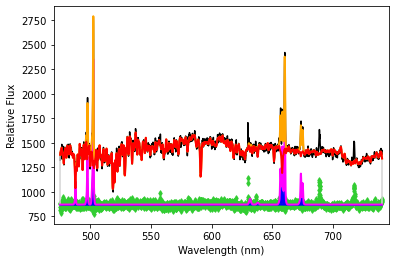

In [99]:
pp = ppxf(stars_gas_templates, galaxy, galaxy*0 + 1, velscale, start,
          plot=1, moments=moments_stars_gas, degree=8, mdegree=-1, vsyst=dv,
          component=component, gas_component=component > 0, tied=tied,
          gas_names=gas_names, constr_kinem=constr_kinem, lam=lam_gal,
          bounds=bounds, global_search=1)

Text(0.5, 1.0, 'Bin = 765/900 (16, 26), (x, y) = (-2.0, 0.4)')

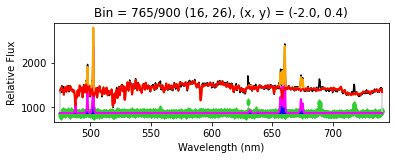

In [100]:
plt.clf()
plt.subplot(211)
pp.plot()
plt.title(f"Bin = {j}/{npix} ({s.col[j]}, {s.row[j]}), (x, y) = ({s.x[j]:.1f}, {s.y[j]:.1f})")

(654.0, 664.0)

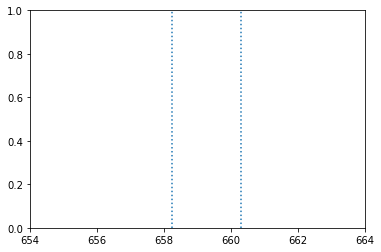

In [101]:
lam = line_wave[gas_names == '[NII]6583_d_(1)']
plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':')
lam = line_wave[gas_names == 'Halpha_(1)']
plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':')
plt.xlim([654, 664])

(494.0, 506.0)

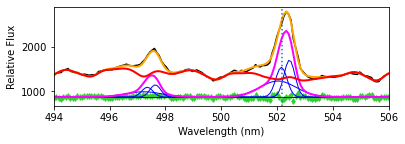

In [102]:
plt.subplot(212)
pp.plot()
lam = line_wave[gas_names == '[OIII]5007_d_(1)']
plt.axvline(lam*np.exp(velbin[k]/C)/10, ls=':')
plt.xlim([494, 506])

noise = robust_sigma(galaxy - pp.bestfit, zero=1)<br>
<br>
for q in range(3):<br>
    gas_vel[j, q], gas_sig[j, q] = pp.sol[q + 1]<br>
    names = ['Halpha', 'Hbeta' , '[NII]6583_d', '[OIII]5007_d']<br>
    for p, name in enumerate(names):<br>
        kk = gas_names == name + f'_({q + 1})'<br>
        dlam = line_wave[kk]*velscale/C   # Angstrom (dlam/lam = dv/c)<br>
        gas_flux[j, q, p] = pp.gas_flux[kk]*dlam  # Convert to ergs/(cm^2 s)<br>
        gas_sn[j, q, p] = np.max(pp.gas_bestfit_templates[:, kk])/noise<br>
<br>
print(f'spaxel: {j} / {npix}')

--------------- end gas fit